## Packages import

In [1]:
import os
import sys
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
# from pykhiops.sklearn import KhiopsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
dataset_name = 'Combined_Cycle_Power_Plant_Dataset'
n_thresholds = 32
classifier_folder = 'RandomForest_classifier'

In [3]:
def load_dataset(path):
    folds_directories = [f.path for f in os.scandir(path)]

    datasets_list = []

    for fold_path in folds_directories:
        datasets_list.append(pd.read_csv(fold_path))
        
    return datasets_list

## Conditional Cumulative Density Function

In [4]:
split_0_extracted_features_dataset = load_dataset(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_thresholds) + '_bins_equal_freq_below_threshold', classifier_folder))[0]

split_0_dataset_length = split_0_extracted_features_dataset.shape[0]

split_0_extracted_features_dataset.head()

,0,1,2,3,class_0,class_1,class_2,class_3,class_4,class_5,...,threshold_27_P(C_0|X),threshold_27_P(C_1|X),threshold_28_P(C_0|X),threshold_28_P(C_1|X),threshold_29_P(C_0|X),threshold_29_P(C_1|X),threshold_30_P(C_0|X),threshold_30_P(C_1|X),threshold_31_P(C_0|X),threshold_31_P(C_1|X)
0,0.03384,0.3643,0.1569,-0.4807,0,0,0,0,0,0,...,0.00,1.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,-0.75630,-1.1610,-0.3440,1.4550,0,0,0,0,0,0,...,0.07,0.93,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-0.76700,-1.2490,0.3242,-1.2330,0,0,0,0,0,0,...,0.00,1.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.34230,-1.0420,-1.9070,-2.1020,0,0,0,0,0,0,...,0.00,1.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.55960,1.6220,0.6167,-0.1267,0,0,0,0,0,0,...,0.00,1.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


### Empirical observation

In [5]:
thresholds_empirical_share = []

for class_col in [e for e in split_0_extracted_features_dataset.columns if 'class' in e.split('_')]:
    thresholds_empirical_share.append(np.sum(split_0_extracted_features_dataset[class_col]) / split_0_dataset_length)

In [6]:
thresholds_empirical_share

[0.03134796238244514,
 0.06687565308254964,
 0.09926854754440961,
 0.11912225705329153,
 0.15151515151515152,
 0.18181818181818182,
 0.2110762800417973,
 0.2413793103448276,
 0.2664576802507837,
 0.296760710553814,
 0.31452455590386624,
 0.34273772204806685,
 0.3657262277951933,
 0.3949843260188088,
 0.4211076280041797,
 0.45454545454545453,
 0.48066875653082547,
 0.522466039707419,
 0.5632183908045977,
 0.5841170323928945,
 0.6185997910135841,
 0.6541274817136886,
 0.6844305120167189,
 0.7105538140020898,
 0.7450365726227796,
 0.7826541274817137,
 0.8108672936259144,
 0.8443051201671892,
 0.877742946708464,
 0.9049111807732497,
 0.9331243469174504,
 0.9728317659352143]

### Classifier's estimation

In [7]:
thresholds_mean_prediction = []

for class_col in [e for e in split_0_extracted_features_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
    thresholds_mean_prediction.append(np.mean(split_0_extracted_features_dataset[class_col]))

In [8]:
thresholds_mean_prediction

[0.035402298850574755,
 0.06468129571577849,
 0.09515151515151517,
 0.12359456635318715,
 0.153866248693835,
 0.18167189132706366,
 0.20713688610240327,
 0.23772204806687555,
 0.2650470219435737,
 0.2926854754440958,
 0.32342737722048037,
 0.34957157784744003,
 0.3770114942528735,
 0.4005329153605017,
 0.42734587251828654,
 0.4547230929989556,
 0.48816091954023005,
 0.5256844305120166,
 0.5574817136886099,
 0.5875130616509923,
 0.6170114942528728,
 0.6509195402298849,
 0.6825287356321829,
 0.7141692789968651,
 0.7471995820271684,
 0.7775653082549634,
 0.8072831765935218,
 0.8421734587251831,
 0.8694148380355278,
 0.8993312434691749,
 0.9337513061650999,
 0.9729467084639507]

### mean absolute difference

In [9]:
np.abs(np.mean(np.array(thresholds_empirical_share) - np.array(thresholds_mean_prediction)))

0.0004313610240334459

### Plot the values

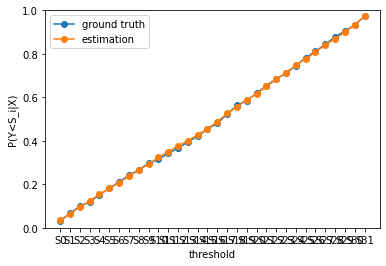

In [10]:
x_axis = ['S' + str(e) for e in list(range(n_thresholds))]

plt.plot(x_axis, thresholds_empirical_share, linestyle='-', marker='o', label='ground truth')
plt.plot(x_axis, thresholds_mean_prediction, linestyle='-', marker='o', label='estimation')

axes = plt.gca()
axes.set_ylim([0, 1])
axes.set_xlabel('threshold')
axes.set_ylabel('P(Y<S_i|X)')
axes.legend()

plt.show()

## Is there a correlation between the quality of the classification and the improvement that our method brings ?

In [11]:
regressor_name = 'LinearRegression_regressor'
regressor_name = 'DecisionTree_regressor'

In [12]:
lrR_DecisionTree_metrics_dataset = load_dataset(os.path.join('..', 'data', 'metrics', dataset_name, '32_bins_equal_freq_below_threshold', 'DecisionTree_classifier', regressor_name))[0]
lrR_Khiops_metrics_dataset = load_dataset(os.path.join('..', 'data', 'metrics', dataset_name, '32_bins_equal_freq_below_threshold', 'Khiops_classifier', regressor_name))[0]
lrR_LogisticRegression_metrics_dataset = load_dataset(os.path.join('..', 'data', 'metrics', dataset_name, '32_bins_equal_freq_below_threshold', 'LogisticRegression_classifier', regressor_name))[0]
lrR_RandomForest_metrics_dataset = load_dataset(os.path.join('..', 'data', 'metrics', dataset_name, '32_bins_equal_freq_below_threshold', 'RandomForest_classifier', regressor_name))[0]
lrR_XGBoost_metrics_dataset = load_dataset(os.path.join('..', 'data', 'metrics', dataset_name, '32_bins_equal_freq_below_threshold', 'XGBoost_classifier', regressor_name))[0]

### AUROC

In [13]:
test_mean_AUROC_lrR_DecisionTree = np.mean(lrR_DecisionTree_metrics_dataset['test_mean_roc_auc_score'])
print('test_mean_AUROC_lrR_DecisionTree =', test_mean_AUROC_lrR_DecisionTree)

test_mean_AUROC_lrR_Khiops = np.mean(lrR_Khiops_metrics_dataset['test_mean_roc_auc_score'])
print('test_mean_AUROC_lrR_Khiops =', test_mean_AUROC_lrR_Khiops)

test_mean_AUROC_lrR_LogisticRegression = np.mean(lrR_LogisticRegression_metrics_dataset['test_mean_roc_auc_score'])
print('test_mean_AUROC_lrR_LogisticRegression =', test_mean_AUROC_lrR_LogisticRegression)

test_mean_AUROC_lrR_RandomForest = np.mean(lrR_RandomForest_metrics_dataset['test_mean_roc_auc_score'])
print('test_mean_AUROC_lrR_RandomForest =', test_mean_AUROC_lrR_RandomForest)

test_mean_AUROC_lrR_XGBoost = np.mean(lrR_XGBoost_metrics_dataset['test_mean_roc_auc_score'])
print('test_mean_AUROC_lrR_XGBoost =', test_mean_AUROC_lrR_XGBoost)

test_mean_AUROC_lrR_DecisionTree = 0.9014335075446132
test_mean_AUROC_lrR_Khiops = 0.9823478205426166
test_mean_AUROC_lrR_LogisticRegression = 0.9790851665106158
test_mean_AUROC_lrR_RandomForest = 0.98708237252711
test_mean_AUROC_lrR_XGBoost = 0.9883990759008053


### F1 score

In [14]:
test_mean_F1_lrR_DecisionTree = np.mean(lrR_DecisionTree_metrics_dataset['test_mean_f1_score'])
print('test_mean_F1_lrR_DecisionTree =', test_mean_F1_lrR_DecisionTree)

test_mean_F1_lrR_Khiops = np.mean(lrR_Khiops_metrics_dataset['test_mean_f1_score'])
print('test_mean_F1_lrR_Khiops =', test_mean_F1_lrR_Khiops)

test_mean_F1_lrR_LogisticRegression = np.mean(lrR_LogisticRegression_metrics_dataset['test_mean_f1_score'])
print('test_mean_F1_lrR_LogisticRegression =', test_mean_F1_lrR_LogisticRegression)

test_mean_F1_lrR_RandomForest = np.mean(lrR_RandomForest_metrics_dataset['test_mean_f1_score'])
print('test_mean_F1_lrR_RandomForest =', test_mean_F1_lrR_RandomForest)

test_mean_F1_lrR_XGBoost = np.mean(lrR_XGBoost_metrics_dataset['test_mean_f1_score'])
print('test_mean_F1_lrR_XGBoost =', test_mean_F1_lrR_XGBoost)

test_mean_F1_lrR_DecisionTree = 0.886282784056997
test_mean_F1_lrR_Khiops = 0.8743549058538468
test_mean_F1_lrR_LogisticRegression = 0.8513467454761582
test_mean_F1_lrR_RandomForest = 0.9114008580564086
test_mean_F1_lrR_XGBoost = 0.9159108654094299


### RMSE

In [15]:
test_mean_RMSE_lrR_DecisionTree = np.mean(lrR_DecisionTree_metrics_dataset['test_root_mean_squared_error'])
print('test_mean_RMSE_lrR_DecisionTree =', test_mean_AUROC_lrR_DecisionTree)

test_mean_RMSE_lrR_Khiops = np.mean(lrR_Khiops_metrics_dataset['test_root_mean_squared_error'])
print('test_mean_RMSE_lrR_Khiops =', test_mean_AUROC_lrR_Khiops)

test_mean_RMSE_lrR_LogisticRegression = np.mean(lrR_LogisticRegression_metrics_dataset['test_root_mean_squared_error'])
print('test_mean_RMSE_lrR_LogisticRegression =', test_mean_AUROC_lrR_LogisticRegression)

test_mean_RMSE_lrR_RandomForest = np.mean(lrR_RandomForest_metrics_dataset['test_root_mean_squared_error'])
print('test_mean_RMSE_lrR_RandomForest =', test_mean_AUROC_lrR_RandomForest)

test_mean_RMSE_lrR_XGBoost = np.mean(lrR_XGBoost_metrics_dataset['test_root_mean_squared_error'])
print('test_mean_RMSE_lrR_XGBoost =', test_mean_AUROC_lrR_XGBoost)

test_mean_RMSE_lrR_DecisionTree = 0.9014335075446132
test_mean_RMSE_lrR_Khiops = 0.9823478205426166
test_mean_RMSE_lrR_LogisticRegression = 0.9790851665106158
test_mean_RMSE_lrR_RandomForest = 0.98708237252711
test_mean_RMSE_lrR_XGBoost = 0.9883990759008053


In [16]:
AUROC_list = [test_mean_AUROC_lrR_DecisionTree,
              test_mean_AUROC_lrR_Khiops,
              test_mean_AUROC_lrR_LogisticRegression,
              test_mean_AUROC_lrR_RandomForest,
              test_mean_AUROC_lrR_XGBoost]

F1_list = [test_mean_F1_lrR_DecisionTree,
           test_mean_F1_lrR_Khiops,
           test_mean_F1_lrR_LogisticRegression,
           test_mean_F1_lrR_RandomForest,
           test_mean_F1_lrR_XGBoost]

RMSE_list = [test_mean_RMSE_lrR_DecisionTree,
             test_mean_RMSE_lrR_Khiops,
             test_mean_RMSE_lrR_LogisticRegression,
             test_mean_RMSE_lrR_RandomForest,
             test_mean_RMSE_lrR_XGBoost]

In [17]:
AUROC_list

[0.9014335075446132,
 0.9823478205426166,
 0.9790851665106158,
 0.98708237252711,
 0.9883990759008053]

In [18]:
F1_list

[0.886282784056997,
 0.8743549058538468,
 0.8513467454761582,
 0.9114008580564086,
 0.9159108654094299]

In [19]:
RMSE_list

[0.25146285043847405,
 0.24155321706616945,
 0.26363257924785544,
 0.20233135968508714,
 0.20018635372393812]

### Plot the values

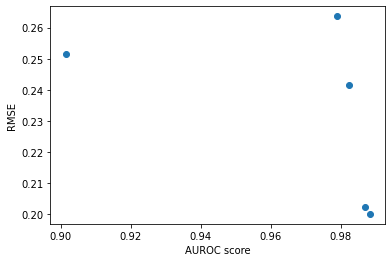

In [20]:
plt.plot(AUROC_list, RMSE_list, linestyle='', marker='o')

axes = plt.gca()
axes.set_xlabel('AUROC score')
axes.set_ylabel('RMSE')

plt.show()

In [21]:
# Correlation of the AUROC and RMSE metrics
np.corrcoef(AUROC_list, RMSE_list)[0, 1]

-0.4687652467873429

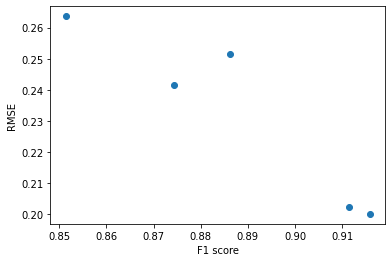

In [22]:
plt.plot(F1_list, RMSE_list, linestyle='', marker='o')

axes = plt.gca()
axes.set_xlabel('F1 score')
axes.set_ylabel('RMSE')

plt.show()

In [6]:
# Correlation of the F1 score and RMSE metrics
np.corrcoef(F1_list, RMSE_list)[0, 1]

NameError: name 'F1_list' is not defined

In [7]:
def plot_F1_RMSE_curve(dataset_name, regressor_name, add_classifiers_labels='True', n_thresholds='32'):
    metrics_to_keep = []
    
    classifiers_directories = [f.path for f in os.scandir(os.path.join('..', 'data', 'metrics', dataset_name, n_thresholds + '_bins_equal_freq_below_threshold'))]

    for classifier_directory in classifiers_directories:
        #if classifier_directory.split(os.path.sep)[-1] != 'DecisionTree_classifier':
        regressors_directories = [f.path for f in os.scandir(classifier_directory)]
        
        for e in regressors_directories:
            if regressor_name == e.split(os.path.sep)[-1]:
                metrics_to_keep.append(e)
                
    tmp_AUROC_list = []
    tmp_RMSE_list = []
    tmp_F1_list = []
    classifiers_labels = []
    
    for path in metrics_to_keep:
        classifiers_labels.append(path.split(os.path.sep)[-2].split('_')[0]
                                  .replace('Classifier', ''))
        tmp_dataset = load_dataset(path)[0]
        
        tmp_RMSE_list.append(np.mean(tmp_dataset['test_root_mean_squared_error']))
        tmp_AUROC_list.append(np.mean(tmp_dataset['test_mean_roc_auc_score']))
        tmp_F1_list.append(np.mean(tmp_dataset['test_mean_f1_score']))
        
    if add_classifiers_labels == 'True':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    ax1.plot(tmp_AUROC_list, tmp_RMSE_list, linestyle='', marker='o')
    ax1.set_title("corr={0:.3f}".format(np.corrcoef(tmp_AUROC_list, tmp_RMSE_list)[0, 1]))
    ax1.set_xlabel('AUROC score')
    ax1.set_ylabel('RMSE')
    
    ax2.plot(tmp_F1_list, tmp_RMSE_list, linestyle='', marker='o')
    ax2.set_title("corr={0:.3f}".format(np.corrcoef(tmp_F1_list, tmp_RMSE_list)[0, 1]))
    ax2.set_xlabel('F1 score')
    ax2.set_ylabel('RMSE')
    
    if add_classifiers_labels == 'True':
        for i, txt in enumerate(classifiers_labels):
            ax1.annotate(txt, (tmp_AUROC_list[i], tmp_RMSE_list[i]))
            ax2.annotate(txt, (tmp_F1_list[i], tmp_RMSE_list[i]))
    
    plt.tight_layout()

## Linear Regression

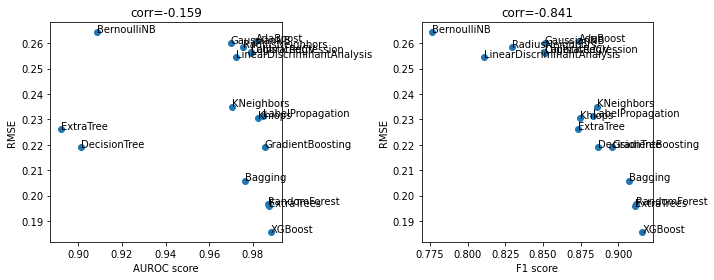

In [8]:
plot_F1_RMSE_curve('Combined_Cycle_Power_Plant_Dataset', 'LinearRegression_regressor')

## Decsion Tree regressor

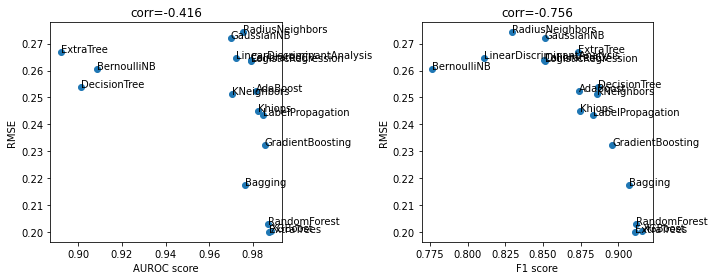

In [9]:
plot_F1_RMSE_curve('Combined_Cycle_Power_Plant_Dataset', 'DecisionTree_regressor')

## Random Forest regressor

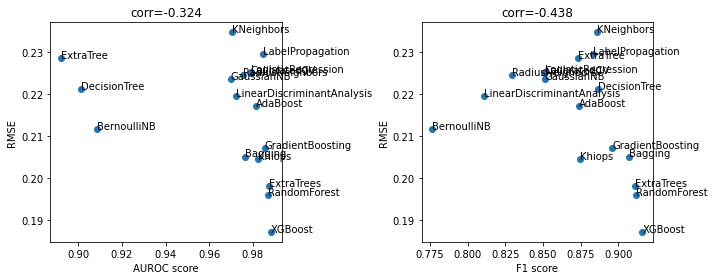

In [10]:
plot_F1_RMSE_curve('Combined_Cycle_Power_Plant_Dataset', 'RandomForest_regressor')

## XGBoost regressor

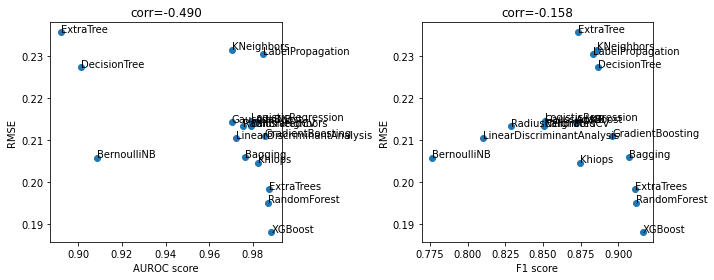

In [11]:
plot_F1_RMSE_curve('Combined_Cycle_Power_Plant_Dataset', 'XGBoost_regressor')

## Khiops regressor

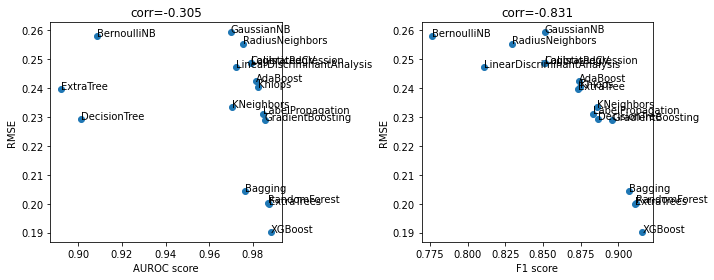

In [12]:
plot_F1_RMSE_curve('Combined_Cycle_Power_Plant_Dataset', 'Khiops_regressor')

## List of the classifiers supporting predict_proba

In [106]:
import sklearn
estimators = sklearn.utils.all_estimators(type_filter=None)
for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(class_)
        # print(name)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble._bagging.BaggingClassifier'>
<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.naive_bayes.CategoricalNB'>
<class 'sklearn.multioutput.ClassifierChain'>
<class 'sklearn.naive_bayes.ComplementNB'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.dummy.DummyClassifier'>
<class 'sklearn.tree._classes.ExtraTreeClassifier'>
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
<class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process._gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
<class 'sklearn.model_selection._search.GridSearchCV'>
<class 'sklearn.model_selection._search_successive_halving.HalvingGridSearchCV'>
<class 'sklearn.model_s

# Wilcoxon Sign-Ranked Test

In [13]:
prefix_path = os.path.join('D:\\', 'results_tables', 'tmp_rmse_for_critical_diagrams')

In [14]:
base_lr_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_LinearRegression_regressor.csv'),
                           usecols=['Base Test RMSE'])['Base Test RMSE'])
base_lr_rmse = [np.float16(e.replace(',', '.')) for e in base_lr_rmse]

new_lr_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_LinearRegression_regressor.csv'),
                           usecols=['32 T Test RMSE'])['32 T Test RMSE'])
new_lr_rmse = [np.float16(e.replace(',', '.')) for e in new_lr_rmse]

base_dt_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_DecisionTree_regressor.csv'),
                           usecols=['Base Test RMSE'])['Base Test RMSE'])
base_dt_rmse = [np.float16(e.replace(',', '.')) for e in base_dt_rmse]

new_dt_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_DecisionTree_regressor.csv'),
                           usecols=['32 T Test RMSE'])['32 T Test RMSE'])
new_dt_rmse = [np.float16(e.replace(',', '.')) for e in new_dt_rmse]

base_rf_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_RandomForest_regressor.csv'),
                           usecols=['Base Test RMSE'])['Base Test RMSE'])
base_rf_rmse = [np.float16(e.replace(',', '.')) for e in base_rf_rmse]

new_rf_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_RandomForest_regressor.csv'),
                           usecols=['32 T Test RMSE'])['32 T Test RMSE'])
new_rf_rmse = [np.float16(e.replace(',', '.')) for e in new_rf_rmse]

base_xgb_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_XGBoost_regressor.csv'),
                           usecols=['Base Test RMSE'])['Base Test RMSE'])
base_xgb_rmse = [np.float16(e.replace(',', '.')) for e in base_xgb_rmse]

new_xgb_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_XGBoost_regressor.csv'),
                           usecols=['32 T Test RMSE'])['32 T Test RMSE'])
new_xgb_rmse = [np.float16(e.replace(',', '.')) for e in new_xgb_rmse]

base_khiops_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_Khiops_regressor.csv'),
                           usecols=['Base Test RMSE'])['Base Test RMSE'])
base_khiops_rmse = [np.float16(e.replace(',', '.')) for e in base_khiops_rmse]

new_khiops_rmse = np.array(pd.read_csv(os.path.join(prefix_path, 'RMSE_table_RandomForest_classifier_Khiops_regressor.csv'),
                           usecols=['32 T Test RMSE'])['32 T Test RMSE'])
new_khiops_rmse = [np.float16(e.replace(',', '.')) for e in new_khiops_rmse]

In [28]:
def create_box_plot(list1, list2, title, precision=6):
    plt.boxplot([list1, list2], showmeans=True)
    plt.gca().xaxis.set_ticklabels(['rmse before', 'rmse after'])
    plt.suptitle(title)
    plt.title("Wilcoxon signed rank test pvalue : " + "%0.*f" % (precision, stats.wilcoxon(list1, list2).pvalue))
    
    
    plt.plot([], [], '-', linewidth=1, color='Crimson', label='median')
    plt.plot([], [], '^', linewidth=1, color='Green', label='mean')
    
    plt.legend()
    
    plt.show()

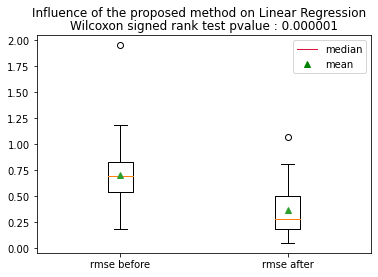

In [29]:
create_box_plot(base_lr_rmse, new_lr_rmse, 'Influence of the proposed method on Linear Regression', precision=6)

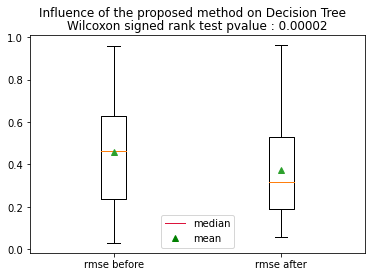

In [30]:
create_box_plot(base_dt_rmse, new_dt_rmse, 'Influence of the proposed method on Decision Tree', precision=5)

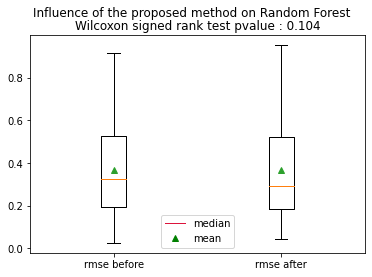

In [31]:
create_box_plot(base_rf_rmse, new_rf_rmse, 'Influence of the proposed method on Random Forest', precision=3)

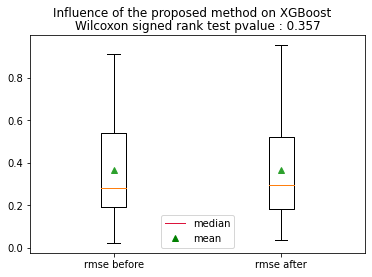

In [32]:
create_box_plot(base_xgb_rmse, new_xgb_rmse, 'Influence of the proposed method on XGBoost', precision=3)

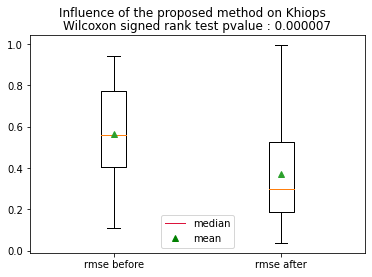

In [33]:
create_box_plot(base_khiops_rmse, new_khiops_rmse, 'Influence of the proposed method on Khiops', precision=6)

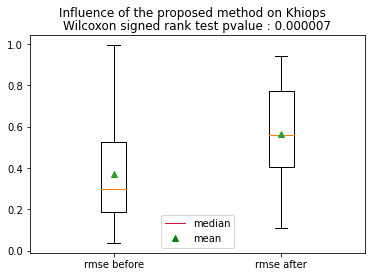

In [34]:
create_box_plot(new_khiops_rmse, base_khiops_rmse, 'Influence of the proposed method on Khiops', precision=6)